###MovieLens 1M data pre-processing

In [16]:
### Downloading the Dataset 

##### For running on Google Colab
# !wget -nc https://files.grouplens.org/datasets/movielens/ml-1m.zip --no-check-certificate
# !unzip -n ml-1m

##### For using a local machine, please use this code instead:
import requests
import zipfile
r = requests.get("https://files.grouplens.org/datasets/movielens/ml-1m.zip")
with open("ml-1m.zip", "wb") as code:
    code.write(r.content)
with zipfile.ZipFile("ml-1m.zip", 'r') as zip_ref:
    zip_ref.extractall(path=None, members=None, pwd=None)

####Loading the ratings data

In [17]:
import numpy as np, pandas as pd, re

dataset = "ml-1m"

ratings = pd.read_table(dataset+'/ratings.dat', sep='::',
                        engine='python', names=["user_id", "movie_id", "rating", "rating_timestamp"])

ratings.drop_duplicates()
print(ratings.shape)
print(ratings.dtypes)

ratings.head()

(1000209, 4)
user_id             int64
movie_id            int64
rating              int64
rating_timestamp    int64
dtype: object


,user_id,movie_id,rating,rating_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [18]:
print("Number of users: %d" % ratings.user_id.drop_duplicates().count())
print("Number of items: %d" % ratings.movie_id.drop_duplicates().count())
print("Number of ratings: %d" % ratings.rating.count())

Number of users: 6040
Number of items: 3706
Number of ratings: 1000209


#### Loading movie data

In [19]:
movies = pd.read_table(dataset+'/movies.dat',
                             sep='::', names=['movie_id', 'title', 'genres'], engine='python', header=0)
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True).astype(int) # extract year from title
print(movies.shape)
print(movies.dtypes)
movies.head()

(3882, 4)
movie_id     int64
title       object
genres      object
year         int32
dtype: object


,movie_id,title,genres,year
0,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
1,3,Grumpier Old Men (1995),Comedy|Romance,1995
2,4,Waiting to Exhale (1995),Comedy|Drama,1995
3,5,Father of the Bride Part II (1995),Comedy,1995
4,6,Heat (1995),Action|Crime|Thriller,1995


In [20]:
movies['genres']=movies.genres.map(lambda x: set(x.split('|')))
present_genres=set()
for movie in movies.itertuples():
    present_genres=present_genres.union(movie.genres) # create a set of all present genres
for genre in present_genres:
    movies['genre'+genre]=movies.genres.map(lambda x: 1.0*(genre in x)) # add dummy encoded columns to movie df
present_genres

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

####User data

#### Loading the user demographic information

In [21]:
users = pd.read_table(dataset+'/users.dat',
                      sep='::', names=["user_id", "gender", "age", "occupation", "Zipcode"], engine='python')
users = users.drop("Zipcode", axis=1)

occupations = {
    0:  "\"other\" or not specified",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}
users['occupation_name'] = users.occupation.map(occupations)
#users['age'] = users.age.map(lambda x: str(x))
users.head()


,user_id,gender,age,occupation,occupation_name
0,1,F,1,10,K-12 student
1,2,M,56,16,self-employed
2,3,M,25,15,scientist
3,4,M,45,7,executive/managerial
4,5,M,25,20,writer


####Merging dataframes into one

Users data preparation

In [22]:
# map gender to numeric values and create mapping dictionaries
num2gender = dict(enumerate(users.gender.unique()))
gender2num = {y:x for x,y in num2gender.items()}
users.gender = users.gender.apply(lambda x: gender2num[x])

print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,occupation_name
0,1,0,1,10,K-12 student
1,2,1,56,16,self-employed
2,3,1,25,15,scientist
3,4,1,45,7,executive/managerial
4,5,1,25,20,writer


In [23]:
# create user-interaction matrix with movie infos
mov = pd.merge(movies, ratings, on="movie_id")
mov = pd.merge(mov, users, on="user_id")

print(mov.shape)
mov.head()

(998132, 29)


,movie_id,title,genres,year,genreDocumentary,genreFantasy,genreAction,genreComedy,genreChildren's,genreMystery,...,genreWestern,genreWar,genreSci-Fi,user_id,rating,rating_timestamp,gender,age,occupation,occupation_name
0,2,Jumanji (1995),"{Adventure, Fantasy, Children's}",1995,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,10,5,979168267,0,35,1,academic/educator
1,7,Sabrina (1995),"{Romance, Comedy}",1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,10,4,978227763,0,35,1,academic/educator
2,24,Powder (1995),"{Sci-Fi, Drama}",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,10,3,978230586,0,35,1,academic/educator
3,32,Twelve Monkeys (1995),"{Sci-Fi, Drama}",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,10,5,979168160,0,35,1,academic/educator
4,48,Pocahontas (1995),"{Musical, Romance, Animation, Children's}",1995,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,10,4,978230090,0,35,1,academic/educator


In [24]:
# create consecutive ids for movies and users
id2movie = dict(enumerate(mov.movie_id.unique()))
movie2id = {y:x for x,y in id2movie.items()}

id2user = dict(enumerate(mov.user_id.unique()))
user2id = {y:x for x,y in id2user.items()}

# add new id columns to df 
mov["iid"] = mov.apply(lambda x: movie2id[x.movie_id], axis=1)
mov["uid"] = mov.apply(lambda x: user2id[x.user_id], axis=1)

In [25]:
print(mov.shape)
mov.sample(frac=1).head(30) # shuffle and show 30 entries

(998132, 31)


,movie_id,title,genres,year,genreDocumentary,genreFantasy,genreAction,genreComedy,genreChildren's,genreMystery,...,genreSci-Fi,user_id,rating,rating_timestamp,gender,age,occupation,occupation_name,iid,uid
21474,2422,"Karate Kid III, The (1989)","{Adventure, Action, Drama}",1989,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,509,2,976297676,1,25,2,artist,574,62
811802,3177,Next Friday (1999),{Comedy},1999,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1047,3,974965076,1,18,0,"""other"" or not specified",2083,3300
269286,2081,"Little Mermaid, The (1989)","{Comedy, Children's, Romance, Musical, Animation}",1989,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,5620,3,969984758,1,35,14,sales/marketing,245,656
459184,950,"Thin Man, The (1934)",{Mystery},1934,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1325,4,974778723,1,25,1,academic/educator,1153,1316
52094,621,My Favorite Season (1993),{Drama},1993,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1181,3,976141753,1,35,7,executive/managerial,3078,134
301422,1081,Victor/Victoria (1982),"{Comedy, Musical}",1982,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,752,3,996518805,0,25,3,clerical/admin,1402,748
306312,2436,Tea with Mussolini (1999),{Comedy},1999,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,927,1,975194693,0,25,20,writer,293,763
562232,3039,Trading Places (1983),{Comedy},1983,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,5345,4,960672620,0,25,17,technician/engineer,335,1735
455857,590,Dances with Wolves (1990),"{Adventure, Western, Drama}",1990,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1267,4,974827423,1,25,15,scientist,50,1308
614497,3408,Erin Brockovich (2000),{Drama},2000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,143,3,977350612,1,18,3,clerical/admin,367,1984


## Data Exploration

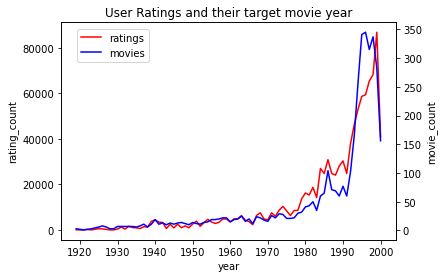

In [26]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df_explore = mov
# mov.drop('genres',1,inplace=True)

# plot rating counts vs. movie counts

## data preparation
rating_counts = mov['year'].value_counts().reset_index()
rating_counts.columns = ["year", "rating_count"]
movie_counts = movies['year'].value_counts().reset_index()
movie_counts.columns = ["year", "movie_count"]
counts_by_year = pd.merge(rating_counts, movie_counts, how="inner", on="year")

## plotting
fig = plt.figure()
rating_line = sns.lineplot(data=counts_by_year, x='year', y='rating_count', color="r", label = 'ratings', legend=0)
ax2 = plt.twinx()
movie_line = sns.lineplot(data=counts_by_year, x='year', y='movie_count', color="b", label = 'movies', legend=0, ax=ax2)
fig.legend(  loc="center left",  bbox_to_anchor=(0.15, 0.8))
plt.title("User Ratings and their target movie year")
plt.show()


Number of movies present: 3882
Avg percentage of movies rated by user: 0.042657783759993566


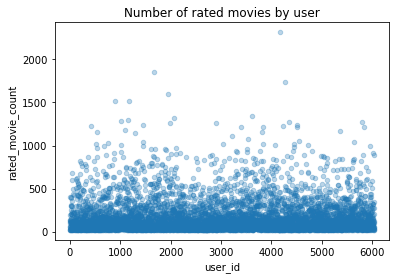

In [27]:
# how many reviews per user?

movies_count = len(movies)
print("Number of movies present:",movies_count)
rating_count_by_user = ratings.groupby(['user_id'])["user_id"].count()
rating_count_by_user = pd.DataFrame(rating_count_by_user)
rating_count_by_user.columns = ["rated_movie_count"]
rating_count_by_user.reset_index().plot(kind="scatter", x="user_id", y="rated_movie_count", alpha=0.3, title="Number of rated movies by user")
rating_ratio_by_user = ratings.groupby(['user_id'])["user_id"].count()/movies_count
print("Avg percentage of movies rated by user:",rating_ratio_by_user.mean())


,user_id,movie_id,rating,rating_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


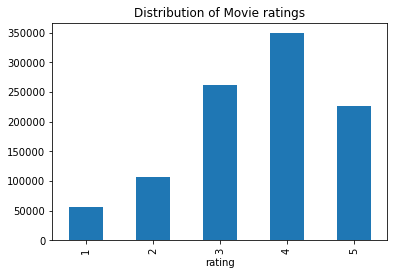

4.0 3.581564453029317


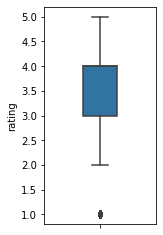

In [28]:
# Plot Distribution of Movie Ratings
display(ratings)
ratings.groupby(['rating'])["rating"].count().plot(kind='bar',title="Distribution of Movie ratings")
plt.show()

median = ratings.rating.median()
avg = ratings.rating.mean()
print(median, avg)
plt.figure(figsize=(2, 4))
fig = sns.boxplot(data=mov, y="rating", width=0.3)


<AxesSubplot:title={'center':'Collected Reviews by Year'}, xlabel='year'>

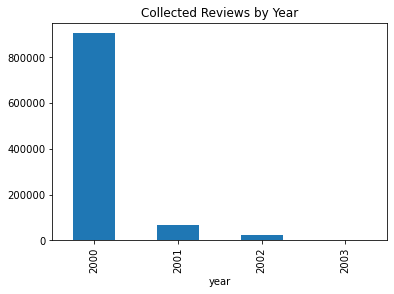

In [29]:
# Data preprocessing 
ratings["rating_datetime"] = pd.to_datetime(ratings["rating_timestamp"], unit='s')
ratings["year"] = ratings['rating_datetime'].dt.year
ratings.set_index("rating_datetime", inplace=True)
ratings.groupby(['year'])["year"].count().plot(kind='bar',title="Collected Reviews by Year")

[Text(0, 0, '< 18'),
 Text(1, 0, '18-24'),
 Text(2, 0, '25-34'),
 Text(3, 0, '35-44'),
 Text(4, 0, '45-49'),
 Text(5, 0, '50-55'),
 Text(6, 0, '>56')]

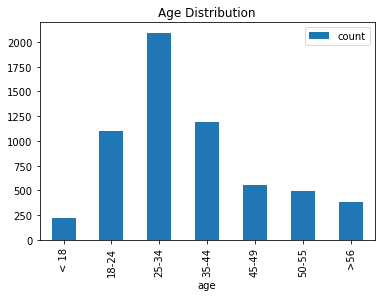

In [30]:
# Distribution of Age among users
users_tmp= users.groupby(['age']).count().reset_index()

users_tmp.drop(columns=["user_id",	"occupation", "occupation_name"], inplace=True)
users_tmp.columns = ["age", "count"]
ax = users_tmp.plot(kind="bar", x="age", y="count", title="Age Distribution")
ax.set_xticklabels(["< 18", "18-24", "25-34", "35-44", "45-49", "50-55", ">56"])

Text(0.5, 1.0, 'Correlations')

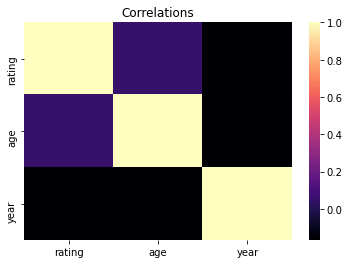

In [31]:
## Check for correlations

# calculate the correlation matrix
corr = mov[["rating", "age", "year"]].corr()

# plot the heatmap
ax = plt.axes()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="magma", ax= ax)
ax.set_title("Correlations")

<ipython-input-32-0127a5348bf8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_genre["rating"] = mov[["rating"]]


Text(0.5, 1.0, 'Genre Correlations')

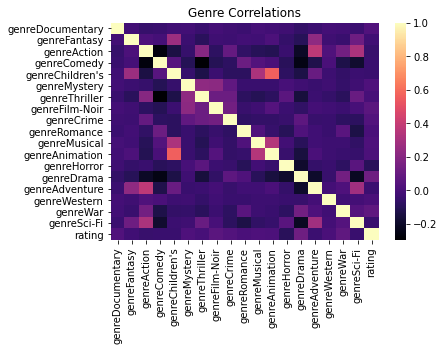

In [32]:
corr_genre = mov.filter(regex='^genre',axis=1)
corr_genre["rating"] = mov[["rating"]]
corr = corr_genre.corr()
ax = plt.axes()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="magma", ax= ax)
ax.set_title("Genre Correlations")

## Recommender System

####Movie Recommendation for Single Users

In [46]:
import pandas as pd
import json
import datetime, time
from sklearn.model_selection import train_test_split
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sp
from sklearn.metrics import roc_auc_score

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
def string2ts(string, fmt="%Y-%m-%d %H:%M:%S"):
    dt = datetime.datetime.strptime(string, fmt)
    t_tuple = dt.timetuple()
    return int(time.mktime(t_tuple))

In [ ]:
users = mov[["uid", "age", "gender", "occupation"]].drop_duplicates()
print(f"Number of users features: {users.shape[0]}")
display(mov.head())
movies = mov[["iid"]+list(mov.columns[3:20])].drop_duplicates()
print(f"Number of movies features: {movies.shape[0]}")

Number of users features: 6040


,movie_id,title,genres,year,genreDocumentary,genreFantasy,genreComedy,genreDrama,genreChildren's,genreMusical,genreHorror,genreWar,genreCrime,genreWestern,genreSci-Fi,genreAction,genreRomance,genreAdventure,genreFilm-Noir,genreThriller,genreMystery,genreAnimation,user_id,rating,rating_timestamp,gender,age,occupation,occupation_name,iid,uid
0,2,Jumanji (1995),"{Fantasy, Adventure, Children's}",1995,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10,5,979168267,0,35,1,academic/educator,0,0
1,7,Sabrina (1995),"{Romance, Comedy}",1995,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10,4,978227763,0,35,1,academic/educator,1,0
2,24,Powder (1995),"{Sci-Fi, Drama}",1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,978230586,0,35,1,academic/educator,2,0
3,32,Twelve Monkeys (1995),"{Sci-Fi, Drama}",1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,5,979168160,0,35,1,academic/educator,3,0
4,48,Pocahontas (1995),"{Romance, Animation, Children's, Musical}",1995,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10,4,978230090,0,35,1,academic/educator,4,0


Number of movies features: 3705


Prepare data for the training

In [ ]:
# create train and test split
train_idx, test_idx = train_test_split(range(mov.shape[0]), test_size=0.2, random_state=42)

train = mov.iloc[train_idx]
# train = pd.concat([train, new_user_train], sort=False)

test = mov.iloc[test_idx]
# test = pd.concat([test, new_user_test], sort=False)

In [ ]:
train = train[["uid", "iid", "rating", "rating_timestamp"]]
test = test[["uid", "iid", "rating", "rating_timestamp"]]


###Siamese Neural Network



####Data pre-processing for Siamese Network

In [ ]:
uids = set(train.uid.unique()).union(set(test.uid.unique()))
iids = set(train.iid.unique()).union(set(test.iid.unique()))

rows = max(uids) + 1
cols = max(iids) + 1

print("Users number: ", len(uids))
print("Movies number: ", len(iids))

Users number:  6040
Movies number:  3705


In [ ]:
def _build_interaction_matrix(rows, cols, data):

    mat = sp.lil_matrix((rows, cols), dtype=np.int32)

    for uid, iid, rating, timestamp in data:
        # Let's assume only really good ratings are positives (ratings above 4) --> idea: maybe create positive if value is above individual user rating avg
        if rating >= 4.0:
            mat[uid, iid] = 1.0

    return mat.tocoo()

def get_triplets(mat):
    return mat.row, mat.col, np.random.randint(mat.shape[1], size=len(mat.row))

def create_sparse_matrix(df):
    """
    Return (train_interactions, test_interactions).
    """
    return _build_interaction_matrix(rows, cols, df.values.tolist())

In [ ]:
def predict(model, uid, pids):
    user_vector = model.get_layer('user_embedding').get_weights()[0][uid]
    item_matrix = model.get_layer('item_embedding').get_weights()[0][pids]

    scores = (np.dot(user_vector,
                     item_matrix.T))
    return scores

def full_auc(model, ground_truth):
    """
    Measure AUC for model and ground truth on all items.

    Returns
    -------
    - float AUC
    """
    ground_truth = ground_truth.tocsr()

    no_users, no_items = ground_truth.shape

    pid_array = np.arange(no_items, dtype=np.int32)

    scores = []

    for user_id, row in enumerate(ground_truth):

        predictions = predict(model, user_id, pid_array)

        true_pids = row.indices[row.data == 1]

        grnd = np.zeros(no_items, dtype=np.int32)
        grnd[true_pids] = 1

        if len(true_pids):
            scores.append(roc_auc_score(grnd, predictions))

    return np.mean(scores)

####Model Implementation

In [ ]:
class TripletLossLayer(Layer):
    def call(self, inputs):
        positive_item_latent, negative_item_latent, user_latent = inputs

        # Bayesian Personalised Ranking (BPR) loss
        loss = 1.0 - K.sigmoid(
            K.sum(user_latent * positive_item_latent, axis=-1, keepdims=True) -
            K.sum(user_latent * negative_item_latent, axis=-1, keepdims=True))

        return loss

In [ ]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

def build_model(num_users, num_items, latent_dim):

    positive_item_input = Input((1, ), name='positive_item_input')
    negative_item_input = Input((1, ), name='negative_item_input')

    # Shared embedding layer for positive and negative items
    item_embedding_layer = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)
    user_input = Input((1, ), name='user_input')

    positive_item_embedding = Flatten()(item_embedding_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_embedding_layer(negative_item_input))
    user_embedding = Flatten()(Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(user_input))
    
    loss = TripletLossLayer()((positive_item_embedding, negative_item_embedding, user_embedding)) # calculate BPR loss
    
    model = Model([positive_item_input, negative_item_input, user_input], loss)
    
    model.compile(loss=identity_loss, optimizer=Adam())
    
    return model

####Training

In [ ]:
latent_dim = 100

# Read data
d_train = create_sparse_matrix(train)
d_test = create_sparse_matrix(test)
num_users, num_items = d_train.shape

# Prepare the test triplets
test_uid, test_pid, test_nid = get_triplets(d_test)

model = build_model(num_users, num_items, latent_dim)

# Print the model structure
print(model.summary())

plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

# Sanity check, should be around 0.5
print(f'AUC before training {full_auc(model, d_test)}')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
positive_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 100)       370500      positive_item_input[0][0]        
                                                                 negative_item_input[0][0]    

In [ ]:
num_epochs = 15 # 15

accuracies_test = []
accuracies_train = []
losses = []

for epoch in range(num_epochs):

    print(f'Epoch {epoch}')

    # Sample triplets from the training data
    uid, pid, nid = get_triplets(d_train)
    
    X = {
        'user_input': uid,
        'positive_item_input': pid,
        'negative_item_input': nid
    }
    # for item in X:
    #   display(item.value)

    history = model.fit(X, 
                      np.ones(len(uid)),
                      batch_size=64,
                      epochs=1,
                      verbose=1,
                      shuffle=True)
    loss = history.history["loss"]
    losses.append(loss)
    
    acc = full_auc(model, d_test)
    accuracies_test.append(acc)
    print(f'Test AUC {acc}')
    acc = full_auc(model, d_train)
    accuracies_train.append(acc)
    print(f'Train AUC {acc}\n')
    print("Loss:", losses[-1])

Epoch 0
7172/7172 [==============================] - 36s 5ms/step - loss: 0.1468
Test AUC 0.883881721568904
Train AUC 0.893402051912322

Loss: [0.1467898190021515]
Epoch 1
7172/7172 [==============================] - 35s 5ms/step - loss: 0.1330
Test AUC 0.8931566536871192
Train AUC 0.9048056988042469

Loss: [0.13296979665756226]
Epoch 2
7172/7172 [==============================] - 35s 5ms/step - loss: 0.1215
Test AUC 0.9007624105853363
Train AUC 0.9140258296397342

Loss: [0.12148323655128479]
Epoch 3
7172/7172 [==============================] - 33s 5ms/step - loss: 0.1149
Test AUC 0.9061839459742618
Train AUC 0.9213455358425822

Loss: [0.11494197696447372]
Epoch 4
7172/7172 [==============================] - 36s 5ms/step - loss: 0.1088
Test AUC 0.9106399823978272
Train AUC 0.9277556727807694

Loss: [0.10880355536937714]
Epoch 5
7172/7172 [==============================] - 35s 5ms/step - loss: 0.1043
Test AUC 0.9141919419317946
Train AUC 0.9328198075777381

Loss: [0.10433626919984818]
E

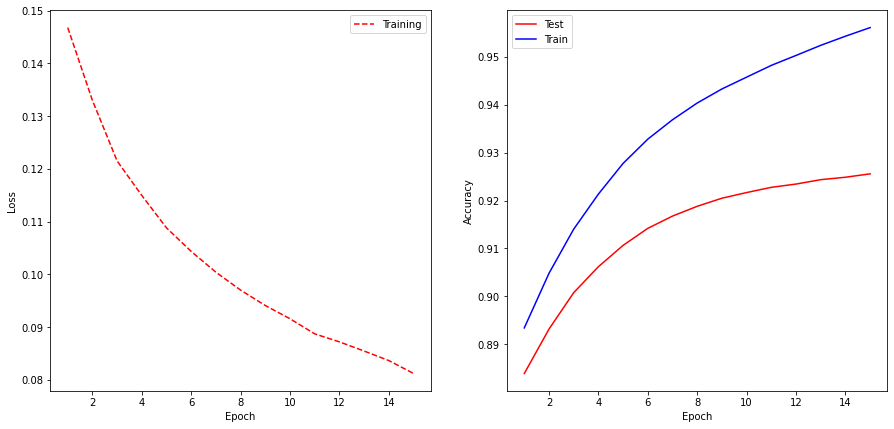

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, num_epochs + 1)

# Visualize loss history
ax1.plot(epoch_count, losses, 'r--', label='Training')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, accuracies_test, 'r-', label='Test')
ax2.plot(epoch_count, accuracies_train, 'b-', label='Train')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
plt.show()

###Observe the recommendation results for our user

In [ ]:
def predict_movies(model, user_id):
    movie_ids = list(mov.iid.unique())
    prediction = predict(model, user_id, movie_ids)
    rated_high = [1 if np.round(i)>0.5 else 0 for i in prediction]
    good_movie_ids = np.where(np.array(rated_high) == 1)[0]  
    return list(good_movie_ids)

In [ ]:
def predict_top_k_movies(model, user_id, k):
    n_users, n_movies = d_train.shape
    prediction = predict(model, user_id, np.arange(n_movies))
    movie_ids = mov.iid.unique()
    return movie_ids[np.argsort(-prediction)][:k]

In [ ]:
import random
user_id = random.choice(users.uid.tolist())

predicted_good_movies = predict_movies(model, user_id)
known_positives = train[(train.iid.isin(d_train.tocsr()[user_id].indices))&(train.uid==user_id)]["iid"]

k = 10
top_movies = predict_top_k_movies(model, user_id, k)

print("User ID:",user_id)
print(f"     {k} Known Likes:")
for x in known_positives[:k]:
    print(f"        {mov[mov.iid==x]['iid'].iloc[0]} | {mov[mov.iid==x]['title'].iloc[0]}" )
    
print(f"     {k} Recommendations:")
for x in top_movies:
    print(f"        {mov[mov.iid==x]['iid'].iloc[0]} | {mov[mov.iid==x]['title'].iloc[0]}" )

print("\nTotal number of movies the user likes:",len(known_positives))
matching_predictions = set(top_movies).intersection(known_positives)
print("Recommendation Accuracy for this user:",len(matching_predictions)/k)

User ID: 4724
     10 Known Likes:
        676 | Devil's Advocate, The (1997)
        1275 | Blair Witch Project, The (1999)
        133 | Army of Darkness (1993)
        1149 | Frighteners, The (1996)
        1047 | Sleepy Hollow (1999)
        1922 | Henry: Portrait of a Serial Killer (1990)
        1067 | Misery (1990)
        180 | Jaws (1975)
        40 | Schindler's List (1993)
        719 | eXistenZ (1999)
     10 Recommendations:
        132 | Alien (1979)
        321 | American Beauty (1999)
        302 | Matrix, The (1999)
        141 | Terminator, The (1984)
        18 | Star Wars: Episode IV - A New Hope (1977)
        314 | Sixth Sense, The (1999)
        7 | Braveheart (1995)
        49 | Terminator 2: Judgment Day (1991)
        674 | Scream (1996)
        124 | Star Wars: Episode V - The Empire Strikes Back (1980)

Total number of movies the user likes: 18
Recommendation Accuracy for this user: 0.0


# Evaluation

In [ ]:
"""## Testing the SAE"""
import torch
import torch.nn as nn
from torch.autograd import Variable

criterion = nn.MSELoss()
dense_test = d_test.todense() # convert sparse to dense matrix

movie_ids = list(mov.iid.unique())
user_ids = list(mov.uid.unique())
test_loss = 0
s = 0.
for uid in user_ids:
  target = torch.from_numpy(dense_test[uid]) # make it a tensor
  if torch.sum(target.data > 0) > 0:
    target.require_grad = False
    output = torch.from_numpy(predict(model, uid, movie_ids)) # make predictions for that user
    loss = criterion(output, target)
    mean_corrector = len(movie_ids)/float(torch.sum(target.data > 0) + 1e-10)
    test_loss += np.sqrt(loss.data*mean_corrector)
    s += 1.
print('test loss: '+str(test_loss/s))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 3705])) that is different to the input size (torch.Size([3705])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


test loss: tensor(162.8375)


# Autoencoders Baseline

In [ ]:
# -*- coding: utf-8 -*-
""" We will implement our Autoencoders with PyTorch, a highly advanced Deep Learning & AI platform.
""  please make sure to install PyTorch on your machine. Below are the Installation Instructions:
    
""   Windows users, please open the anaconda prompt, which you can find this way:
Windows Button in the lower left corner -> List of programs -> anaconda -> anaconda prompt
Then inside the anaconda prompt, copy paste and enter each of the following line commands separately:

                    conda install -c pytorch pytorch

Note : I personally did not use this command.  I created a virtual environment in Anaconda, because 
I didn't want to mess up my tensorflow installation.

please try to install the Pytorch and make this code run.

--------- 
"" (Explanation): In this code you will see how the AEs are being used to predict the rating. 
As you have also seen in the code, we are going to sue the MovieLens dataset. 
""

"""##Importing the libraries"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable


"""## Importing the dataset"""

# We won't be using this dataset.
# movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
# users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings.columns = ["user_id", "movie_id", "rating", "time"]

# create consecutive ids for movies and users
id2movie = dict(enumerate(ratings.movie_id.unique()))
movie2id = {y:x for x,y in id2movie.items()}

id2user = dict(enumerate(ratings.user_id.unique()))
user2id = {y:x for x,y in id2user.items()}

ratings["movie_id"] = ratings.apply(lambda x: movie2id[x.movie_id], axis=1)
ratings["user_id"] = ratings.apply(lambda x: user2id[x.user_id], axis=1)

"""## Preparing the training set and the test set"""
training_set = ratings.iloc[train_idx]
training_set = np.array(training_set, dtype = 'int')

test_set = ratings.iloc[test_idx]
test_set = np.array(test_set, dtype = 'int')

# training_set = ratings.iloc[train_idx]
# test_set = ratings.iloc[test_idx]

display(training_set)
"""## Getting the number of users and movies"""
"""##(Explanation): we need to convert our training and test set into matrix, the rows are going to be the users
and the columns are going to be the ratings. this matrix we will create for the training and the test set"""

# nb_users = int(max(max(training_set[:, 0], ), max(test_set[:, 0])))
# nb_movies = int(max(max(training_set[:, 1], ), max(test_set[:, 1])))

nb_users = len(ratings["user_id"].unique())
nb_movies = len(ratings["movie_id"].unique())
# print(nb_users, nb_movies)
"""## Converting the data into an array with users in lines and movies in columns"""


def convert(data):
  new_data = []
  for id_users in range(1, nb_users + 1): # for each user
    id_movies = data[:, 1] [data[:, 0] == id_users]
    id_ratings = data[:, 2] [data[:, 0] == id_users]
    ratings = np.zeros(nb_movies)
    ratings[id_movies - 1] = id_ratings
    new_data.append(list(ratings))
  return new_data
training_set = convert(training_set)
test_set = convert(test_set)

"""## Converting the data into Torch tensors"""
"""##(Explanation): in order to build our network using Pytorch, we need to create tensors.
 Tensors are multidimentional Arrays. """

training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

"""## Creating the architecture of the Neural Network (Autoencoders)"""

class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

"""## Training the SAE"""

nb_epoch = 200 #200
losses_baseline = []
for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0.
  for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0)
    target = input.clone()
    if torch.sum(target.data > 0) > 0:
      output = sae(input)
      target.require_grad = False
      output[target == 0] = 0
      loss = criterion(output, target)
      mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
      loss.backward()
      train_loss += np.sqrt(loss.data*mean_corrector)
      s += 1.
      optimizer.step()
  print('epoch: '+str(epoch),'loss: '+ str(train_loss/s))
  losses_baseline.append(train_loss/s)

"""## Testing the SAE"""

test_loss = 0
s = 0.
for id_user in range(nb_users):
  input = Variable(training_set[id_user]).unsqueeze(0)
  target = Variable(test_set[id_user]).unsqueeze(0)
  if torch.sum(target.data > 0) > 0:
    output = sae(input)
    target.require_grad = False
    output[target == 0] = 0
    loss = criterion(output, target)
    mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
    test_loss += np.sqrt(loss.data*mean_corrector)
    s += 1.
print('test loss: '+str(test_loss/s))

array([[     2163,        26,         4, 974616477],
       [      955,        43,         5, 975130437],
       [     2180,      1790,         4, 974609613],
       ...,
       [      853,      1471,         3, 975355597],
       [     4032,       842,         5, 965525805],
       [      785,      1075,         4, 975429588]])

epoch: 1 loss: tensor(1.3102)
epoch: 2 loss: tensor(1.0043)
epoch: 3 loss: tensor(0.9875)
epoch: 4 loss: tensor(0.9820)
epoch: 5 loss: tensor(0.9795)
epoch: 6 loss: tensor(0.9779)
epoch: 7 loss: tensor(0.9770)
epoch: 8 loss: tensor(0.9763)
epoch: 9 loss: tensor(0.9760)
epoch: 10 loss: tensor(0.9757)
epoch: 11 loss: tensor(0.9753)
epoch: 12 loss: tensor(0.9752)
epoch: 13 loss: tensor(0.9752)
epoch: 14 loss: tensor(0.9749)
epoch: 15 loss: tensor(0.9748)
epoch: 16 loss: tensor(0.9745)
epoch: 17 loss: tensor(0.9745)
epoch: 18 loss: tensor(0.9744)
epoch: 19 loss: tensor(0.9742)
epoch: 20 loss: tensor(0.9742)
epoch: 21 loss: tensor(0.9739)
epoch: 22 loss: tensor(0.9734)
epoch: 23 loss: tensor(0.9725)
epoch: 24 loss: tensor(0.9713)
epoch: 25 loss: tensor(0.9703)
epoch: 26 loss: tensor(0.9698)
epoch: 27 loss: tensor(0.9695)
epoch: 28 loss: tensor(0.9682)
epoch: 29 loss: tensor(0.9668)
epoch: 30 loss: tensor(0.9672)
epoch: 31 loss: tensor(0.9674)
epoch: 32 loss: tensor(0.9656)
epoch: 33 loss: t

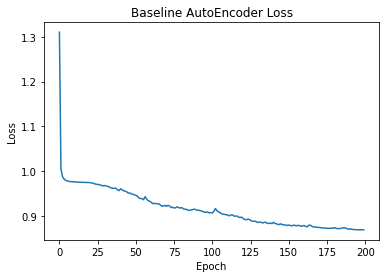

In [ ]:
losses_bl = pd.DataFrame(losses_baseline)
losses_bl.columns = ["loss"]
losses_bl.plot(title="Baseline AutoEncoder Loss", legend=0, xlabel="Epoch", ylabel="Loss")